In [ ]:
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import model_selection, datasets, metrics, tree, ensemble
from sklearn.model_selection import ParameterGrid
from scipy.interpolate import griddata

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns

import time

##Готовим данные

In [ ]:
regression_problem = datasets.make_regression(n_samples=10000, n_features=100,
                                              n_informative=50, random_state=42)

In [ ]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(regression_problem[0],
                                                                                    regression_problem[1],
                                                                                    test_size=0.25,
                                                                                    random_state=42)

Вспомогательная функция для обучения моделей и замера качества на train/test из семинара для задачи регрессии.

In [ ]:
def fit_and_metrics(estimator, train_data, train_labels, test_data, test_labels):
    start_time = time.time()
    estimator.fit(train_data, train_labels)
    print(f'Learning time = {round(time.time() - start_time, 3)} s')
    
    predictions = estimator.predict(train_data)
    print(f'Train: {round(metrics.mean_squared_error(train_labels, predictions), 5)}')

    predictions = estimator.predict(test_data)
    print(f'Test: {round(metrics.mean_squared_error(test_labels, predictions), 5)}')
    
    return estimator

##Строим модели

Дерево решений

Реализуем **grid search** для дерева решений, случайного леса, градиентного бустинга.

In [ ]:
def grid_search(X_train, y_train, parameters, model_type):
  """
  X_train - numpy array переменных на обучающей выборке
  y_train - numpy array таргетов на обучающей выборке
  parameters - словарь гиперпараметров
  model_type - строка, тип модели : 'decision_tree' - дерево решений, 'random_forest' - случайный лес, 'gradient_boosting' - градиентый бустинг 
  """
  #отщепим от обучающей выборки 15 % наблюдений, на которых будем валидировать модель, подбирая гиперпараметры
  train_data, valid_data, train_labels, valid_labels = model_selection.train_test_split(X_train, y_train, test_size=0.15, random_state=42)

  #изначально инициализируем лучшее значение MSE как результат модели на основе алгоритма, который выдает в качестве ответа константу - среднее значение таргета на обучающей выборке.
  best_MSE = round(metrics.mean_squared_error(valid_labels, valid_labels.shape[0] * [train_labels.mean()]))

  param_list = list(ParameterGrid(parameters))

  if model_type == 'decision_tree':

    best_param = {
        'max_depth' : 0,
        'min_samples_leaf' : 0
    }

    for cand in param_list:
      tree_regressor=tree.DecisionTreeRegressor(max_depth=cand['max_depth'], min_samples_leaf=cand['min_samples_leaf'], random_state=42)
      tree_regressor.fit(train_data, train_labels)
      predictions_valid = tree_regressor.predict(valid_data)
      valid_tree_MSE = metrics.mean_squared_error(valid_labels, predictions_valid)

      if valid_tree_MSE < best_MSE:
        best_MSE = valid_tree_MSE
        best_param['max_depth'] = cand['max_depth']
        best_param['min_samples_leaf'] = cand['min_samples_leaf']

  elif model_type == 'random_forest':

    best_param = {
     'n_estimators' : 0,
     'max_depth' : 0,
     'min_samples_leaf' : 0
      }

    for cand in param_list:
      forest_regressor=ensemble.RandomForestRegressor(n_estimators=cand['n_estimators'],max_depth=cand['max_depth'], min_samples_leaf=cand['min_samples_leaf'], random_state=42)
      forest_regressor.fit(train_data, train_labels)
      predictions_valid = forest_regressor.predict(valid_data)
      valid_tree_MSE = metrics.mean_squared_error(valid_labels, predictions_valid)

      if valid_tree_MSE < best_MSE:
        best_MSE = valid_tree_MSE
        best_param['n_estimators'] = cand['n_estimators']
        best_param['max_depth'] = cand['max_depth']
        best_param['min_samples_leaf'] = cand['min_samples_leaf']

  elif model_type == 'gradient_boosting':

    best_param = {
     'n_estimators' : 0,
     'max_depth' : 0,
     'learning_rate' : 0
      }

    for cand in param_list:
      LGBM_regressor=lgb.LGBMRegressor(max_depth=cand['max_depth'], learning_rate=cand['learning_rate'], n_estimators=cand['n_estimators'], random_state=42)
      LGBM_regressor.fit(train_data, train_labels)
      predictions = LGBM_regressor.predict(valid_data)
      valid_tree_MSE = metrics.mean_squared_error(valid_labels, predictions)

      if valid_tree_MSE < best_MSE:
        best_MSE = valid_tree_MSE
        best_param['n_estimators'] = cand['n_estimators']
        best_param['max_depth'] = cand['max_depth']
        best_param['learning_rate'] = cand['learning_rate']


  return best_param
  

Изначально возьмём широкую сетку для максимальной глубины и минимального количества объектов для в листе для разделения.

In [ ]:
dt_parameters={
            "max_depth" : [2,4,6,8,10],
           "min_samples_leaf":[500,750,1000,1250,1500]}

In [ ]:
best_param = grid_search(train_data, train_labels, dt_parameters, 'decision_tree')
best_param

{'max_depth': 4, 'min_samples_leaf': 500}

Теперь попробуем локализовать нашу сетку относительно значений гиперпараметров, полученных для широкой сетки.

In [ ]:
dt_local_parameters={
            "max_depth" : [3,4,5],
           "min_samples_leaf":[450,500,550]}

In [ ]:
best_param = grid_search(train_data, train_labels, dt_local_parameters, 'decision_tree')
best_param

{'max_depth': 4, 'min_samples_leaf': 450}

Посмотрим на MSE для обучающей и тестовой выборок.

In [ ]:
tree_regressor=fit_and_metrics(tree.DecisionTreeRegressor(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.313 s
Train: 127833.34764
Test: 129548.61735


Подобранные гиперпараметры: максмальная глубина = 4, минимальный порог для разделения = 450.

В итоге значение MSE на тестовой выборке $\approx$ 129549, разность между MSE на обучающей и тестовых выборках $\approx$ 1716, то есть мы вписались в требования задания.

Аргументировать выбор данного набора гиперпараметров можно тем, что для него эмпирически в результате перебора получились лучшие значения MSE при валидации.

Теперь добавим обоснование выбора именно этих параметров, подвигав их значения.

In [ ]:
tree_regressor_new_1=fit_and_metrics(tree.DecisionTreeRegressor(max_depth=best_param['max_depth']-2, min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.198 s
Train: 139462.86755
Test: 135271.51828


In [ ]:
tree_regressor_new_2=fit_and_metrics(tree.DecisionTreeRegressor(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf']+50, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.298 s
Train: 129954.49652
Test: 131002.67661


В двух новых моделях выше, в одной из которых мы **уменьшили глубину дерева**, а в другой **повысили порог для разделения узла**, можно видеть, что показатель **MSE ухудшился**, то есть заметно **недообучение моделей** из-за маленькой глубины в первом случае и из-за малого числа листьев во втором случае, поэтому эти новые параметры хуже подходят под наш датасет.

In [ ]:
tree_regressor_new_3=fit_and_metrics(tree.DecisionTreeRegressor(max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf']-50, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.31 s
Train: 127833.34764
Test: 129548.61735


В третьей новой модели при **уменьшении порога для разделения** мы не видим изменений, обновлять гиперпараметры не имеет смысла.

In [ ]:
tree_regressor_new_4=fit_and_metrics(tree.DecisionTreeRegressor(max_depth=best_param['max_depth']+2, min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 0.307 s
Train: 128603.63903
Test: 130201.9069


В четвертой новой модели при **увеличении глубины дерева** MSE ухудшается.

Визуализируем дерево (узлы в последних слоях наложились друг на друга, но в беседе обсуждали, что важны только первые 2-3 уровня).

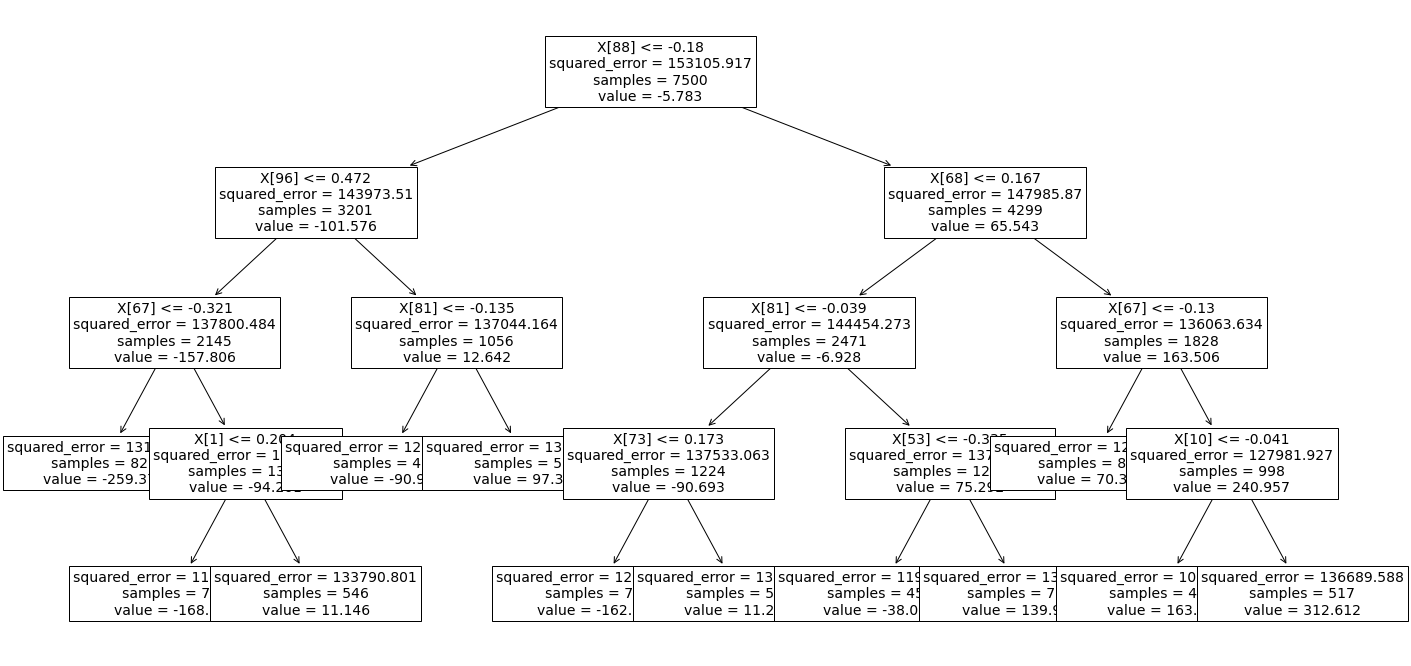

In [ ]:
plt.figure(figsize = (24, 12))
txt = tree.plot_tree(tree_regressor, fontsize=14)

Выведем 2 самых важных признака.

In [ ]:
feats = {}
for feature, importance in enumerate(tree_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(2)

,Features,Gini-Importance
0,88,0.270353
1,68,0.161020


Визуализируем сплиты по **двум самым значимым признакам** для дерева.

In [ ]:
def plot_decision_surface(i, j, data, labels, split_1, split_2, left_flg):
    """
        i - номер первого признака
        j - номер второго признака
        data - выборка с признаками
        labels - выборка с таргетом
        split_1 - значение из условия на первый признак
        split_2 - значение из условия на второй признак
        left_flg - флаг того, что второй признак рассматривается при выполнении
        в дереве условия на первый признак
    """
    x = data[:, i]
    y = data[:, j]
    z = labels
    
    resolution = '50j'
    X, Y = np.mgrid[min(x):max(x):complex(resolution), min(y):max(y):complex(resolution)]
    points = [[a,b] for a,b in zip(x,y)]
    Z = griddata(points, z, (X, Y), method='linear')

    plt.figure(figsize=(14, 10))
    plt.contourf(X, Y, Z, cmap='winter')
    plt.colorbar()
    plt.plot([split_1, split_1], [y.min(), y.max()], 'r', linewidth=5, label='First split')
    if left_flg:
        split_list = [x.min(), split_1]
    else:
        split_list = [split_1, x.max()]
    plt.plot(split_list, [split_2, split_2], 'm', linewidth=5, label='Second split')
    plt.legend()
    plt.xlabel(f'X[{i}]')
    plt.ylabel(f'X[{j}]')
    plt.show()

In [ ]:
first_feature_number = 88
second_feature_number = 68

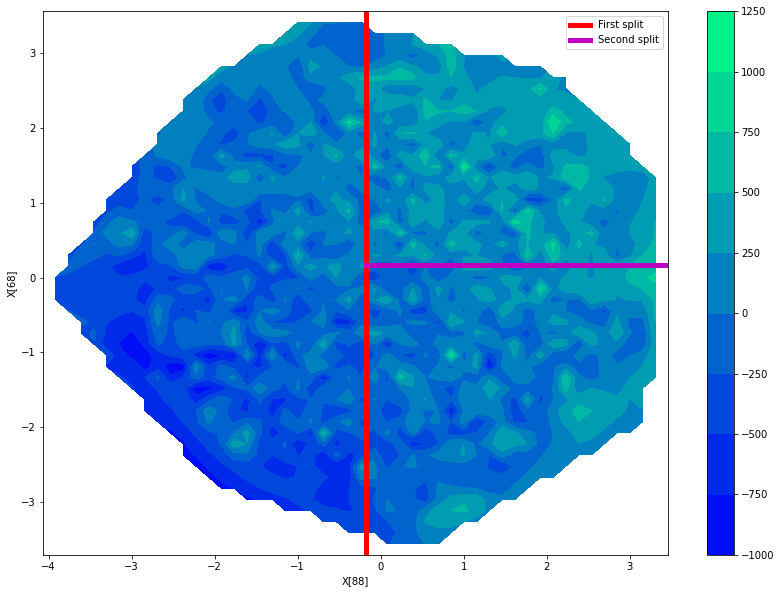

In [ ]:
plot_decision_surface(first_feature_number, second_feature_number, train_data, train_labels, -0.18, 0.167, False)

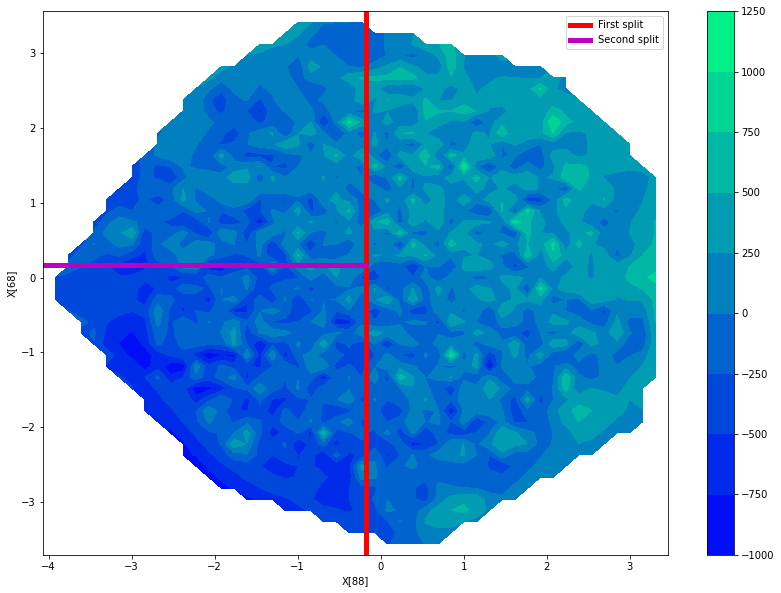

In [ ]:
plot_decision_surface(first_feature_number, second_feature_number, train_data, train_labels, -0.18, 0.167, True)

В случае, когда мы вырезаем правый нижний угол, то есть область, в которую попали объекты, для которых не выполняется условие на 1 признак $(X[88] > -0.18)$ и выполняется условие на 2 признак $(X[68] <= 0.167)$, заметно, что в ней присутствуют множество зелёных очагов, которые соответствуют положительным значениям целевой переменной, и если мы посмотрим на визуализацию дерева, можно отметить, что в  узлах левой ветви относительно второго признака value примерно равномерно принимает положительные значения, так и отрицательные. 

Напротив, когда мы вырезаем левый нижний угол, область, в которую попали объекты, для которых выполняется как условие на 1 признак $(X[88] <= -0.18)$, так и условие на 2 признак $(X[68] <= 0.167)$, видно, что в ней меньше зелёных зон, то есть объектов с отрицательным таргетом больше, и если мы снова посмотрим на визуализацию дерева, то убедимся, что в узлах левой ветви относительно первого признака value, в основном, принимает отрицательные значения.

Случайный лес

Возьмем широкую сетку

In [ ]:
rf_parameters={
            "n_estimators" : [5, 50, 100],
            "max_depth" : [5,10],
            "min_samples_leaf":[100, 500]}

In [ ]:
best_param = grid_search(train_data, train_labels, rf_parameters, 'random_forest')
best_param

{'max_depth': 10, 'min_samples_leaf': 100, 'n_estimators': 100}

Как и в случае с деревом решений, локализуем сетку относительно лучших гиперпараметров, полученных из широкой сетки.

In [ ]:
local_rf_parameters={
            "n_estimators" : [80, 100, 120],
            "max_depth" : [8, 10, 12],
            "min_samples_leaf":[75, 100, 125]}

In [ ]:
best_param = grid_search(train_data, train_labels, local_rf_parameters, 'random_forest')
best_param

{'max_depth': 10, 'min_samples_leaf': 75, 'n_estimators': 120}

In [ ]:
forest_regressor=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 33.25 s
Train: 84911.07839
Test: 95435.52414


В итоге значение MSE на тестовой выборке $\approx$ 95436, разность между MSE на обучающей и тестовых выборках $\approx$ 10525, всё в рамках ограничений.

В результате перебора различных вариантов гиперпараметров было решено взять количество деревьев в ансамбле = 120, максимальную глубину = 10 и минимальный порог разделения = 75.

Снова попробуем подвигать значения гиперпараметров относительно выбранного набора.

In [ ]:
new_forest_regressor_1=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators']-40, max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 22.249 s
Train: 85040.39198
Test: 95535.95224


In [ ]:
new_forest_regressor_2=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators']+40, max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 44.515 s
Train: 84816.85409
Test: 95466.94633


При изменении количества деревьев в ансамбле мы не получаем существенного улучшения показателя MSE, а при увеличении числа деревьев ещё и проигрываем по времени.

In [ ]:
new_forest_regressor_3=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth']-5, min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 29.234 s
Train: 96221.36962
Test: 102736.20761


In [ ]:
new_forest_regressor_4=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth']+5, min_samples_leaf=best_param['min_samples_leaf'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 33.406 s
Train: 84911.07839
Test: 95435.52414


При урезании максимальной длины мы видим ухудшение показателя MSE, что может говорить о недообучении, а при увеличении глубины нет никаких улучшений. 

In [ ]:
new_forest_regressor_5=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf']-25, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 36.514 s
Train: 75555.06566
Test: 90554.40852


In [ ]:
new_forest_regressor_6=fit_and_metrics(ensemble.RandomForestRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], min_samples_leaf=best_param['min_samples_leaf']+25, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 31.217 s
Train: 91032.82065
Test: 99015.42822


При понижении порога разделения у нас улучшился показатель MSE как на обучающей, так и на тестовой выборке, но при этом сильно выросла разница, что свидетельсвует о переобучении.

Если же мы повышаем порог, то показатели MSE ухудшаются, что может говорить о недообучении.

Выведем топ-10 признаков по значимости

In [ ]:
feats = {}
for feature, importance in enumerate(forest_regressor.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
importances.head(10)

,Features,Gini-Importance
0,88,0.146963
1,67,0.103218
2,81,0.098123
3,68,0.088582
4,53,0.079722
5,1,0.077443
6,96,0.066223
7,10,0.062840
8,89,0.039564
9,28,0.038835


Видим, что два самых значимых признака для дерева решений попали и в топ-10 самых важных признаков случайного леса (88 - 1 место, 68 - 4 место)

Градиентный бустинг LGBM

Снова возьмем широкую сетку.

In [ ]:
gb_parameters={
            "n_estimators" : [1000, 2000],
            "max_depth" : [1, 2],
            "learning_rate" : [0.1, 0.15]}

In [ ]:
best_param = grid_search(train_data, train_labels, gb_parameters, 'gradient_boosting')
best_param

{'learning_rate': 0.15, 'max_depth': 1, 'n_estimators': 2000}

Как и в случае с деревом решений и случайным лесом, локализуем сетку относительно набора гиперпараметров с широкой сетки.

In [ ]:
local_gb_parameters={
            "n_estimators" : [1750, 2000, 2250],
            "max_depth" : [1, 2],
            "learning_rate" : [0.13, 0.15, 0.17]}

In [ ]:
best_param = grid_search(train_data, train_labels, local_gb_parameters, 'gradient_boosting')
best_param

{'learning_rate': 0.17, 'max_depth': 1, 'n_estimators': 2250}

In [ ]:
lgbm_regressor=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 3.432 s
Train: 967.61245
Test: 2092.17689


В итоге значение MSE на тестовой выборке $\approx$ 1124, разность между MSE на обучающей и тестовых выборках $\approx$ 5560, в плане ограничений всё в порядке.

Гиперпараметры: количество деревьев в ансамбле = 2250, максимальная глубина = 1, длина шага = 0.17 были выбраны в результате перебора различных вариантов, далее приведём дополнительные пояснения, подвигав полученный набор.

In [ ]:
new_lgbm_regressor_1=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators']-300, max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 3.031 s
Train: 1126.94846
Test: 2383.74089


In [ ]:
new_lgbm_regressor_2=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators']+300, max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 3.878 s
Train: 878.0956
Test: 1915.80402


Заметим, что при уменьшении числа деревьев в ансамбле показатели MSE немного ухудшились, а при увеличении незначительно улучшились, причём разницы в MSE для нашей модели и первой новой модели $\approx$ 159 и 292 для обучающей и тестовой выборок соответственно, а разницы в MSE для нашей модели и второй новой модели
$\approx$ 90 и 176 аналогично. То есть можно сказать, что где-то **после 2000-2500 деревьев в ансамбле показатели MSE выходят на плато**, так что можно без существенных потерь брать число деревьев $\approx$ 2000.

In [ ]:
new_lgbm_regressor_3=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth']+1, learning_rate=best_param['learning_rate'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 5.78 s
Train: 634.19072
Test: 6193.90921


In [ ]:
new_lgbm_regressor_4=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth']+2, learning_rate=best_param['learning_rate'], random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 9.555 s
Train: 77.33393
Test: 10763.74977


Здесь видно, что при **увеличении глубины дерева на 1-2 уровня** мы начинаем **очень сильно переобучаться**, и чем больше слоёв мы добавим, тем плачевнее будет ситуация.

In [ ]:
new_lgbm_regressor_5=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate']-0.1, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 3.35 s
Train: 4748.43383
Test: 7321.45721


In [ ]:
new_lgbm_regressor_5=fit_and_metrics(lgb.LGBMRegressor(n_estimators=best_param['n_estimators'], max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate']+0.1, random_state=42),
                           train_data, train_labels, test_data, test_labels)

Learning time = 3.439 s
Train: 1024.24266
Test: 2195.32659


Заметно, что при изменении длины шага относительно выбранного нами значения, показатели MSE ухудшаются, так что learning rate менять не стоит.

Выведем топ-10 наиболее значимых признаков.

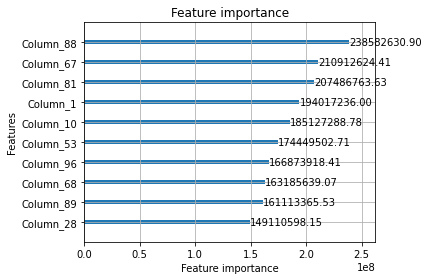

In [ ]:
lgb.plot_importance(lgbm_regressor, importance_type='gain', max_num_features=10, precision=2)
plt.tight_layout()
plt.show()

Отметим, что в топ-10 попали 2 самых важных признака для решающего дерева (88 - 3 место, 68 - 6 место). 
Также в топ попали все 10 признаков, которые были наиболее значимы для случайного леса.

Построим зависимость MSE от числа деревьев для обучающей и тестовой выборок.

In [ ]:
number_estimators = []
mse_train = []
mse_test = []

for n in range(500, 5000, 250):

  number_estimators.append(n)

  lgbm_regressor=lgb.LGBMRegressor(n_estimators=n, max_depth=best_param['max_depth'], learning_rate=best_param['learning_rate'], random_state=42)
  
  lgbm_regressor.fit(train_data, train_labels)
  
  predictions_train = lgbm_regressor.predict(train_data)
  predictions_test = lgbm_regressor.predict(test_data)

  mse_train.append(round(metrics.mean_squared_error(train_labels, predictions_train), 2))

  mse_test.append(round(metrics.mean_squared_error(test_labels, predictions_test), 2))

Text(0, 0.5, 'MSE')

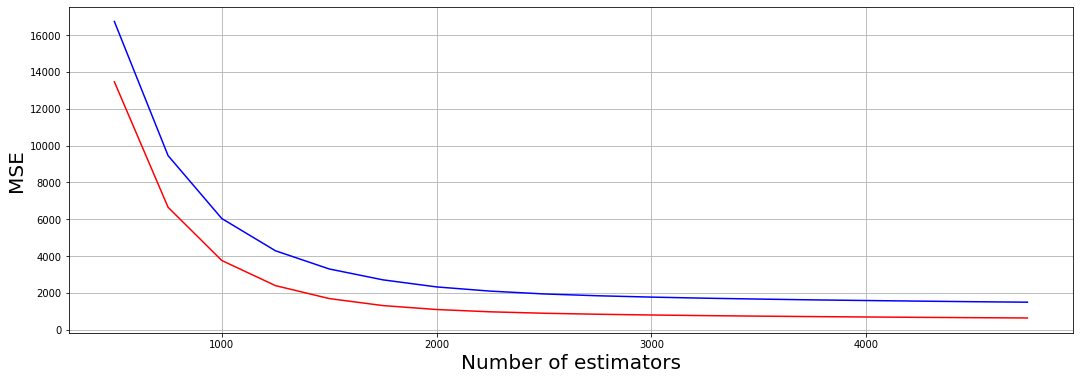

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.grid(True)

plt.plot(number_estimators, mse_train, color='red', label = 'train')
plt.plot(number_estimators, mse_test, color='blue', label = 'test')
plt.xlabel('Number of estimators', fontsize=20)
plt.ylabel('MSE', fontsize=20)

Из графика можно сделать вывод, что начиная примерно с 2000 деревьев в бустинге MSE как для обучающей, так и для тестовой выборки начинает стабилизироваться, соответственно если мы выберем число деревьев меньшее, чем то, что было получено перебором, мы ухудшим показатели, а если увеличим количество деревьев, то немного улучшим MSE и разность в показателях для обучающей и тестовой выборок.